# Modelo Random Forest para encuesta Reddit Chile

## Conexión a fuente de datos

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_pickle("data/df_encuesta.pkl")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1181
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   edad                       1170 non-null   int32
 1   religion                   1170 non-null   int8 
 2   sexo_Hombre                1170 non-null   uint8
 3   sexo_Mujer                 1170 non-null   uint8
 4   orientacion_Bisexual       1170 non-null   uint8
 5   orientacion_Heterosexual   1170 non-null   uint8
 6   orientacion_Homosexual     1170 non-null   uint8
 7   ocupacion_Estudio          1170 non-null   uint8
 8   ocupacion_Ninguna          1170 non-null   uint8
 9   ocupacion_Trabajo          1170 non-null   uint8
 10  ocupacion_Trabajo;Estudio  1170 non-null   uint8
 11  region_I                   1170 non-null   uint8
 12  region_II                  1170 non-null   uint8
 13  region_III                 1170 non-null   uint8
 14  region_IV               

# Selección de variables predictoras y de respuesta.

In [5]:
X = df.loc[:, ~df.columns.isin(['politica_izquierda'])]
y = df['politica_izquierda']

# Generación data de entrenamiento y testeo más balanceo

In [6]:
# creamos ahora muestras de entrenamiento y prueba seleccionadas aleatoriamente:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state = 42)

In [7]:
# balaceo con sobremuestro
y_train_Q = y_train[y_train == 1]
y_train_NQ = y_train[y_train == 0]
y_train_NQ = y_train_NQ.sample(len(y_train_Q), replace = True, 
                               random_state = 42)
y_train = pd.concat([y_train_Q, y_train_NQ], axis=0)
X_train = X_train.loc[y_train.index,:]

del [y_train_Q, y_train_NQ]

In [8]:
# datos de entrenamiento despueés de balanceo
y_train.value_counts()

1    517
0    517
Name: politica_izquierda, dtype: int64

# CV y RandomSearchCV

In [9]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

12

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

modelo = RandomForestClassifier(criterion = 'entropy',
                               n_estimators = 1000)

cv = cross_validate(modelo,
                    X,
                    y,
                    cv = 5,
                    n_jobs = cores,
                    return_train_score = True)
cv

{'fit_time': array([2.27319884, 2.35816717, 2.30818272, 2.46694589, 2.30204368]),
 'score_time': array([0.14088798, 0.15263367, 0.154773  , 0.14235139, 0.14395809]),
 'test_score': array([0.61965812, 0.61538462, 0.64957265, 0.58119658, 0.58547009]),
 'train_score': array([0.99465812, 0.99465812, 0.99465812, 0.9957265 , 0.99465812])}

In [11]:
from sklearn.model_selection import RandomizedSearchCV
import time

start = time.time()

param_grid = {'bootstrap': [True, False],
              'max_depth': [4, 6, 8, 10, 12, None],
              'max_features': [None, 'sqrt', 'log2'],
              'min_samples_leaf': [0.1, 0.2, 0.3],
              'min_samples_split': [0.1, 0.2, 0.3],
              'criterion' :['gini', 'entropy'],
              'n_estimators': [100, 200, 500, 1000]}

rf = RandomForestClassifier(random_state = 42, n_jobs = cores)
grid_search = RandomizedSearchCV(estimator = rf, 
                                 param_distributions = param_grid,
                                 n_iter = 200,
                                 cv = 5,
                                 random_state = 42,
                                 verbose = 1)

grid_search.fit(X_train, y_train)

end = time.time()
print(end - start)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
366.22477889060974


In [12]:
modelo = grid_search.best_estimator_
modelo

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=6,
                       max_features='log2', min_samples_leaf=0.1,
                       min_samples_split=0.2, n_estimators=200, n_jobs=12,
                       random_state=42)

In [13]:
modelo.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=6,
                       max_features='log2', min_samples_leaf=0.1,
                       min_samples_split=0.2, n_estimators=200, n_jobs=12,
                       random_state=42)

# Resultados modelo

## Matrices de confusión

In [14]:
y_pred_train = modelo.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=["Y_predicha"],index = y_train.index)

from sklearn.metrics import classification_report
print("Resultado en Muestra de Entrenamiento:")

print(classification_report(y_train, y_pred_train))

Resultado en Muestra de Entrenamiento:
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       517
           1       0.62      0.69      0.65       517

    accuracy                           0.63      1034
   macro avg       0.63      0.63      0.63      1034
weighted avg       0.63      0.63      0.63      1034



In [15]:
y_pred_test = modelo.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=["Y_predicha"],index = y_test.index)

print("Resultado en Muestra de Prueba:")

print(classification_report(y_test, y_pred_test))

Resultado en Muestra de Prueba:
              precision    recall  f1-score   support

           0       0.65      0.54      0.59       117
           1       0.61      0.71      0.65       117

    accuracy                           0.62       234
   macro avg       0.63      0.62      0.62       234
weighted avg       0.63      0.62      0.62       234



**Precision**: Cada vez que el modelo determina que un usuario de Reddit es de izquierda, acertará un 61% de las veces.  
**Recall**: El modelo es capaz de identificar al 71% de las personas que son efectivamente de izquierda.  
**Accuracy**: El modelo acierta un 62% de las veces.

## Curva ROC y PR

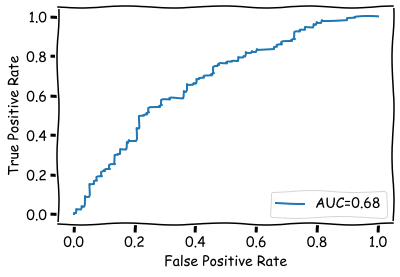

In [16]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_prob_test = modelo.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_test)
auc = round(metrics.roc_auc_score(y_test, y_prob_test),2)

with plt.xkcd():
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

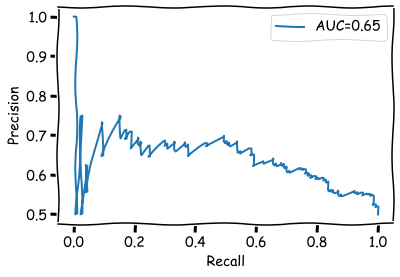

In [17]:
with plt.xkcd():
    pr = metrics.precision_recall_curve(y_test, y_prob_test)
    auc_pr = round(metrics.average_precision_score(y_test, y_prob_test), 2)
    plt.plot(pr[1], pr[0], label="AUC="+str(auc_pr))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.legend(loc=1)
    plt.show()

## Variance Importance Factor

In [18]:
vil = pd.DataFrame(list(zip(X.columns,modelo.feature_importances_)),
                   columns=['feature','Feature Importances']
                  ).sort_values(by='Feature Importances', ascending=False)
vil.head()

,feature,Feature Importances
1,religion,0.189682
5,orientacion_Heterosexual,0.157693
42,perro_lipigas,0.150974
27,educacion_media,0.056706
0,edad,0.054126
